# Session 5 (Bonus): Implementing a simple Eco-Evolutionary simulation

In all precedent sessions, we saw how to control simulation from notebook by modifying agents behaviors, manipulating their sensors, their diets ... how to make resources spawn, assign species to agents ......, attach routines ...

Now we are going to see how we can combine all these features to implement a simple Eco-Evolutionary simulation ! 

An eco-evolutionary simulation is a virtual environment where small agents (like robots) interact with each other and their surroundings. Over time, these agents adapt and evolve based on environmental challenges and competition for resources. The simulation models both ecological processes (like food gathering or predator-prey relationships) and evolutionary changes (like traits being passed down to future generations).

In [25]:
controller.stop()

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE


In [1]:
import numpy as np
import matplotlib.colors as colors

from vivarium.controllers.notebook_controller import NotebookController
#from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

Start running the controller and check the subtypes of this session

In [2]:
controller = NotebookController()

In [3]:
controller.simulator_config.num_steps_lax = 20

In [4]:
controller.run()

In [5]:
controller.agents[0].left_motor = 0.5
controller.print_subtypes_list()

['C', 'resources', 'B', 'A']


In [6]:
controller.agents[0].left_motor = 0.

In [7]:
import numpy as np

def with_bias(x):
    return np.hstack([x, 1])

def relu(x):
    return np.maximum(0, x)

class StateSpaceModel:
    def __init__(self, A, B, C, D, x0):
        """
        Initialize the State Space Model.
        
        Parameters:
        A (np.ndarray): State transition matrix. Defines how the state evolves from one time step to the next in the absence of any control input.
        B (np.ndarray): Control input matrix. Defines how control inputs affect the state.
        C (np.ndarray): Observation matrix. Defines how the state is mapped to the observed measurements.
        D (np.ndarray): Feedthrough matrix. Directly maps the control input to the observed measurements.
        Q (np.ndarray): Process noise covariance. Represents the uncertainty in the state transition.
        R (np.ndarray): Measurement noise covariance. Represents the uncertainty in the observations.
        x0 (np.ndarray): Initial state. The starting state of the system.
        """
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        # self.Q = Q
        # self.R = R
        self.x = x0
        # self.P = np.eye(A.shape[0])  # Initial state covariance

    def infer(self, u):
        self.x = relu(self.A @ with_bias(self.x)) + relu(self.B @ with_bias(u))
        y = relu(self.C @ with_bias(self.x))  + relu(self.D @ with_bias(u))
        return y


In [26]:
x_dim = 4
u_dim = 3
y_dim = 2

A = np.random.normal(0, 0.1, (x_dim, x_dim + 1))  # np.array([[1, 1], [0, 1]])  # State transition matrix
B = np.random.normal(0, 0.1, (x_dim, u_dim + 1))  #       # Control input matrix
C = np.random.normal(0, 0.1, (y_dim, x_dim + 1))  # np.array([[1, 0]])          # Observation matrix
D = np.random.normal(0, 0.1, (y_dim, u_dim + 1))  # np.array([[0, 0]])          # Feedthrough matrix

x0 = np.array([0, 1, 0.5, 0.])           # Initial state

model = StateSpaceModel(A, B, C, D, x0)

In [27]:
with_bias(x0)

array([0. , 1. , 0.5, 0. , 1. ])

In [28]:
u = np.array([0, 0, 0])

model.infer(u)

array([-0.00106215,  0.17674446])

In [ ]:

    # def predict(self, u):
    #     """
    #     Predict the next state and covariance.
        
    #     Parameters:
    #     u (np.ndarray): Control input. The input applied to the system at the current time step.
        
    #     Returns:
    #     np.ndarray: Predicted state. The estimated state of the system at the next time step.
    #     np.ndarray: Predicted state covariance. The estimated uncertainty of the predicted state.
    #     """
    #     self.x = self.A @ self.x + self.B @ u
    #     self.P = self.A @ self.P @ self.A.T + self.Q
    #     return self.x, self.P

    # def update(self, y):
    #     """
    #     Update the state and covariance with a new observation.
        
    #     Parameters:
    #     y (np.ndarray): Observation. The measurement obtained from the system at the current time step.
        
    #     Returns:
    #     np.ndarray: Updated state. The corrected state estimate after incorporating the new observation.
    #     np.ndarray: Updated state covariance. The corrected uncertainty of the state estimate.
    #     """
    #     S = self.C @ self.P @ self.C.T + self.R
    #     K = self.P @ self.C.T @ np.linalg.inv(S)
    #     self.x = self.x + K @ (y - self.C @ self.x)
    #     self.P = self.P - K @ self.C @ self.P
    #     return self.x, self.P

# Example usage
A = np.array([[1, 1], [0, 1]])  # State transition matrix
B = np.array([[0.5], [1]])      # Control input matrix
C = np.array([[1, 0]])          # Observation matrix
D = np.array([[0]])             # Feedthrough matrix
Q = np.eye(2) * 0.1             # Process noise covariance
R = np.eye(1) * 0.1             # Measurement noise covariance
x0 = np.array([0, 1])           # Initial state

model = StateSpaceModel(A, B, C, D, Q, R, x0)

# Predict the next state with control input u
u = np.array([1])
predicted_state, predicted_covariance = model.predict(u)
print("Predicted state:", predicted_state)

# Update the state with a new observation y
y = np.array([1.2])
updated_state, updated_covariance = model.update(y)
print("Updated state:", updated_state)



In [19]:
# Calculate the output
predicted_output = C @ predicted_state + D @ u
print("Predicted output:", predicted_output)

Predicted output: [1.5]


In [8]:
import numpy as np
# Define the recurrent network function with ReLU activation
def recurrent_network(input, hidden_state, params):
    # Add a bias term to the input
    input_with_bias = np.hstack([input, np.ones((input.shape[0], 1))])
    # Concatenate input with the hidden state
    combined_input = np.hstack([input_with_bias, hidden_state])
    # Calculate the weighted sum
    weighted_sum = np.dot(combined_input, params.T)
    # Apply the ReLU function
    output = np.maximum(0, weighted_sum)
    return output

# # Example usage

# dim_s = 2
# dim_h = 3
# dim_m =2

# input = np.random.rand(1, dim_s)  # Define a single 2D input
# params = np.random.rand(dim_m + dim_h, dim_s + 1 + dim_h)  # Define params
# hidden_state = np.zeros((1, dim_h))  # Initialize hidden state
# output = recurrent_network(input, hidden_state, params)
# print(output)




In [9]:
# class RNNBehavior:

#     def behavior(sensed, params):
#             def fn(agent):
#                 s = agent.sensors(sensed_entities=[sensed])
#                 input = np.hstack((s, agent.energy))
#                 out = recurrent_network(input.reshape(1, -1), agent.hidden_state[sensed].reshape(1, -1), params).reshape(-1)
#                 agent.hidden_state[sensed] = out[:agent.hidden_state.shape[0]].reshape(-1)
#                 m = np.clip(out[agent.hidden_state.shape[0]:], 0, 1)
#                 return m[0], m[1]
#             return fn

#     def attach(self, agent, params_dict, hidden_state_dim=0):
#         agent.hidden_state = np.zeros(hidden_state_dim)
#         agent.behavior_fn = self.fn

#     def init_params(self, agent, sensed):


def rnn_behavior(sensed, params):
    def fn(agent):
        s = agent.sensors(sensed_entities=[sensed])
        input = np.hstack((s, agent.energy))
        out = recurrent_network(input.reshape(1, -1), agent.hidden_state[sensed].reshape(1, -1), params).reshape(-1)
        agent.hidden_state[sensed] = out[:agent.hidden_state[sensed].shape[0]].reshape(-1)
        m = np.clip(out[agent.hidden_state[sensed].shape[0]:], 0, 1)
        return m[0], m[1]
    return fn
    
def ssm_behavior(sensed):
    def fn(agent):
        s = agent.sensors(sensed_entities=[sensed])
        input = np.hstack((s, agent.energy))
        out = agent.ssm.infer(input)
        if np.any(np.isnan(out)):
            agent.energy = -10.
            return 0, 0
        m = np.clip(out, 0, 1)
        return m[0], m[1]
    return fn

In [10]:
def attach_rnn_behaviors(agent):
    for entity, params in agent.genome['behavior_params'].items():
        agent.attach_behavior(rnn_behavior(entity, params), name=f'{entity}_behavior', interval=1)

def attach_ssm_behaviors(agent):
    for entity, params in agent.genome['behavior_params'].items():
        agent.ssm = StateSpaceModel(params['A'], params['B'], params['C'], params['D'], params['x0'])
        agent.attach_behavior(ssm_behavior(entity), name=f'{entity}_behavior', interval=1)

In [11]:
init_energy = 1.

max_age = 500

min_dist = 60  # 10
max_dist = 60.01  #80

min_cos = 0.49  # -0.9
max_cos = 0.51  # 0.9

def dist_cos(gene):
    gene = np.clip(gene, 0, 1)
    dist = min_dist + (max_dist - min_dist) * gene
    cos = min_cos + (max_cos - min_cos) * gene
    return dist, cos

In [12]:
def energy(agent):
    if agent.has_eaten():
        agent.energy += 2.
        # print('has_eaten', agent.energy)
    else:
        agent.energy -= 0.002 + 0.003 * (agent.left_motor + agent.right_motor) / 2
        # print('lose energy', agent.energy)
    agent.energy = min(agent.energy, 3.5)

def death(agent):
    if agent.energy <= 0 or agent.age > max_age:
        agent.exists = False
        agent.detach_all_behaviors(stop_motors=True)
        agent.detach_all_routines()
        agent.age = 0
        agent.evo_age = 0

def age_routing(agent):
    agent.age += 1

In [13]:
hidden_state_dim = 0
s_dim = 3 # sensor + energy
m_dim = 2 # motor

def init_agent(agent, species, position=None, genome=None):
    agent.energy = init_energy
    agent.ate = False
    agent.age = 0
    
    if position is not None:
        agent.x_position = position[0]
        agent.y_position = position[1]
    else:
        agent.x_position = np.random.uniform(0, controller.box_size)
        agent.y_position = np.random.uniform(0, controller.box_size)
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.exists = True
    agent.species = species
    agent.subtype_label = species
    if genome is not None:
        agent.genome = genome
        # It is an offspring, so:
        agent.evo_age += 1
        agent.hidden_state = {}
        for entity in controller.subtypes_labels.values():
            agent.hidden_state[entity] = np.zeros(hidden_state_dim)
    else:
        # It is not an offspring, so:
        agent.evo_age = 0
        agent.genome = {}
        agent.genome['dist_cos'] = np.random.rand()
        agent.genome['behavior_params'] = {}
        agent.hidden_state = {}
        for entity in controller.subtypes_labels.values():
            agent.hidden_state[entity] = np.zeros(hidden_state_dim)
            agent.genome['behavior_params'][entity] = np.random.normal(0, 0.5, (m_dim + hidden_state_dim, s_dim + 1 + hidden_state_dim))
            # agent.genome['behavior_params'][entity]['A'] = np.random.normal(0, 0.1, (hidden_state_dim, hidden_state_dim + 1))
            # agent.genome['behavior_params'][entity]['B'] = np.random.normal(0, 0.1, (hidden_state_dim, s_dim + 1))
            # agent.genome['behavior_params'][entity]['C'] = np.random.normal(0, 0.1, (m_dim, hidden_state_dim + 1))
            # agent.genome['behavior_params'][entity]['D'] = np.random.normal(0, 0.1, (m_dim, s_dim + 1))
            # agent.genome['behavior_params'][entity]['x0'] = np.random.normal(0, 0.1, (hidden_state_dim,))

    dist, cos = dist_cos(agent.genome['dist_cos'])
    agent.proxs_dist_max = dist
    agent.proxs_cos_min = cos
    agent.diet = ['B', 'resources'] if agent.species == "A" else (['C', 'resources'] if agent.species == "B" else ['A', 'resources'])
    agent.color = colors.to_hex((int(agent.species == 'A'), int(agent.species == 'B'), int(agent.species == 'C')))
    attach_rnn_behaviors(agent)

def start_agent(agent):
    agent.start_all_behaviors()
    agent.attach_routine(energy, interval=1)
    agent.attach_routine(death, interval=1)
    agent.attach_routine(age_routing, interval=1)    

In [14]:
# for agent in controller.agents:
#     init_agent(agent)


n_ag_per_species = 5

for agent in controller.agents[:n_ag_per_species]:
    init_agent(agent, 'A')
for agent in controller.agents[n_ag_per_species:2*n_ag_per_species]:
    init_agent(agent, 'B')
for agent in controller.agents[2*n_ag_per_species:3*n_ag_per_species]:
    init_agent(agent, 'C')

In [15]:
for agent in controller.agents[3*n_ag_per_species:]:
    init_agent(agent, 'A')
    agent.exists = False
    

In [16]:
# spawn the a new agent every time an agent has eaten !
max_distance = 30.

def asexual_reproduction(controller):
    # iterate over all agents in the controller
    for robot in controller.agents: 
        # check if the robot has eaten and if it is alive
        if robot.exists and robot.energy > 2 * init_energy:
            print('REPRODUCTION STARTED')
            # get the index of the dead agents to select one and make it spawn
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            # check if there are dead agents (if dead_agents_idx an empty list, do nothing)
            if dead_agents_idx:
                robot.energy -= init_energy
                # if there are dead agents, select one randomly
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position of the parent
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [robot.x_position, robot.y_position]
                new_position = position + epsilon

                # give the new position to the spawn entity
                offspring = controller.agents[agent_idx]  #controller.spawn_entity(agent_idx, position=new_position) 
                genome = {}
                genome['dist_cos'] = np.random.normal(robot.genome['dist_cos'], 0.05)
                genome['dist_cos'] = np.clip(genome['dist_cos'], 0, 1)
                # behavior_params = {entity: np.clip(np.random.normal(params, 0.05), -2., 2.)
                #                    for entity, params in robot.genome['behavior_params'].items()}
                behavior_params = {}
                for entity, params in robot.genome['behavior_params'].items():
                    behavior_params[entity] = np.random.normal(params, 0.05)
                    # for k, v in params.items():
                    #     behavior_params[entity][k] = np.random.normal(v, 0.05)
                genome['behavior_params'] = behavior_params
                init_agent(offspring, robot.species, position=new_position, genome=genome)   
                start_agent(offspring)
                #attach_param_behaviors(offspring)
                #offspring.energy = init_energy
                #offspring.attach_routine(energy, interval=1)
                #offspring.attach_routine(death, interval=1)
                #offspring.start_all_behaviors()

                print('REPRODUCTION DONE')
            else:
                pass

In [17]:
def spontaneous_agent_birth(controller):
    for species in controller.subtypes_labels.values():
        if species == 'resources':
            continue
        if sum(ag.exists for ag in controller.agents if agent.species == species) <= 5:
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            if dead_agents_idx:
                agent_idx = np.random.choice(dead_agents_idx)
                ag = controller.agents[agent_idx]
                init_agent(ag, species)
                start_agent(ag)

In [18]:
from collections import defaultdict
population_size = defaultdict(list)
def population_size_routine(controller):
    population_size['agents'].append(sum(ag.exists for ag in controller.agents))
    population_size['resources'].append(sum(o.exists for o in controller.objects))

In [19]:
#controller.detach_routine('population_size_routine')


In [20]:
controller.attach_routine(spontaneous_agent_birth, interval=1)
controller.start_resources_apparition(interval=40)
controller.attach_routine(asexual_reproduction, interval=1)
#controller.attach_routine(population_size_routine, interval=100)

Species C ate species resources
REPRODUCTION STARTED
REPRODUCTION DONE
Species B ate species resources
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species B
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species B
Species A ate species B
Species A ate species resources
Species B ate species resources
Species A ate species B
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species B
Species B ate species C
Species A ate species B
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species B
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species B
Species A ate species B
Species B ate species resources
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION

In [ ]:
# for agent in controller.agents:
#     start_agent(agent)

REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION 

In [24]:
for ag in controller.agents:
    ag.eating_range = 20

REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
Species B ate species C
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
Species A ate species resources
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
Species A ate species B
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
Species B ate species C
REPRODUCTION STARTED
REPRODUCTION DONE
Species B ate species C
Species B ate species C
Species A ate species B
Species B ate species C
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
Species B ate species C
Species B ate species C
Species A ate species resources
Species B ate species C
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
Species B ate species C
Species B ate species C
Species B ate species C


In [28]:
controller.stop_resources_apparition()

Resources apparition is already stopped


In [29]:
controller.start_resources_apparition(interval=10)


In [19]:
[(ag.energy, ag.exists) for ag in controller.agents]

[(1.0800000000000027, True),
 (1.120000000000013, True),
 (1.0200000000000093, True),
 (0.47499999999999953, True),
 (1.130000000000022, True),
 (1.53500000000001, True),
 (1.6300000000000052, True),
 (0.4349999999999995, True),
 (0.13000000000000456, True),
 (0.5250000000000018, True),
 (0.0050000000000036205, True),
 (0.12500000000000455, True),
 (0.25500000000001, True),
 (1.485000000000003, True),
 (1.005000000000003, True),
 (0.00999999999999918, True),
 (1.3350000000000337, True),
 (0.13499999999999923, True),
 (0.9099999999999999, True),
 (1.1150000000000122, True)]

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTI

In [ ]:
for i, ag in enumerate(controller.agents):
    for entity, params in ag.genome['behavior_params'].items():
        print(f'Agent {i}')
        print(entity)
        print(params)
        print(f'evo_age ={ag.evo_age}')

Agent 0
robots
[[ 0.62998309 -0.02342618  0.64601082  0.75789701]
 [-0.42578042  0.10272707 -0.4541436  -0.10596628]]
evo_age =1
Agent 0
resources
[[-0.17810931 -0.58893701 -0.16304986 -0.1194593 ]
 [ 1.65935995 -1.76387894  0.57606763  0.38257967]]
evo_age =1
Agent 1
robots
[[ 0.71620068 -0.02363256  0.71533953  0.60230836]
 [-0.4494319   0.16266352 -0.41404121 -0.07389681]]
evo_age =1
Agent 1
resources
[[-0.13047085 -0.664247   -0.08266078 -0.03719156]
 [ 1.65074078 -1.76565011  0.6957528   0.22886072]]
evo_age =1
Agent 2
robots
[[ 0.61329886 -0.16195488  0.63635163  0.59264062]
 [-0.3994695   0.25032041 -0.37146479  0.11924796]]
evo_age =0
Agent 2
resources
[[-0.03356002 -0.6125102  -0.33702087 -0.19113878]
 [ 1.46119246 -1.7158104   0.53366279  0.41181395]]
evo_age =0
Agent 3
robots
[[ 0.71167406 -0.04337044  0.65775522  0.6332779 ]
 [-0.41255581  0.18251095 -0.37859242 -0.16247506]]
evo_age =0
Agent 3
resources
[[-0.17057174 -0.62207548 -0.09536273 -0.11652836]
 [ 1.6141595  -1.74

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE


In [35]:
population_size

defaultdict(list, {'agents': [13, 9, 6], 'resources': [4, 7, 10]})

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE


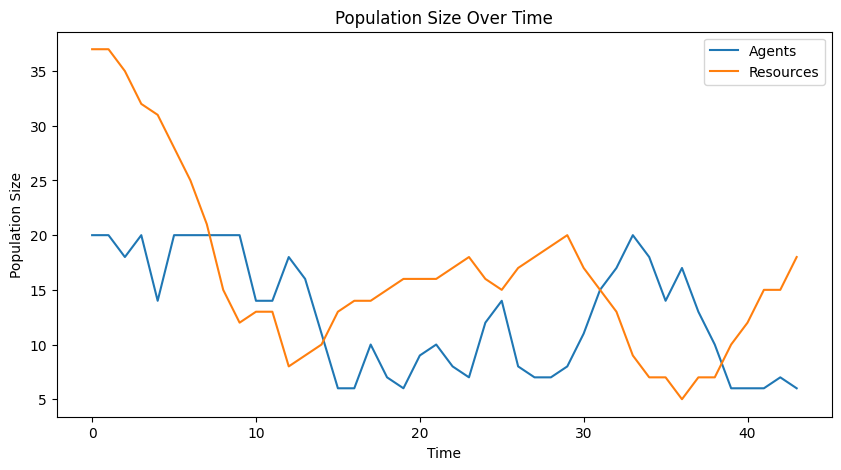

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPR

In [22]:
import matplotlib.pyplot as plt

# Plot the population size over time
plt.figure(figsize=(10, 5))
plt.plot(population_size['agents'], label='Agents')
plt.plot(population_size['resources'], label='Resources')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Population Size Over Time')
plt.legend()
plt.show()

In [ ]:
[agent.evo_age for agent in controller.agents if agent.exists]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE
REPRODUCTION STARTED
REPRODUCTION DONE


In [18]:
controller.detach_routine('spontaneous_agent_birth')

KeyError: 'spontaneous_agent_birth'

In [20]:
controller.attach_routine(spontaneous_agent_birth, interval=1)


In [ ]:
for agent in controller.agents:
    agent.detach_routine('energy')
    agent.attach_routine(energy, interval=1)

In [19]:
controller.stop()

In [22]:
for agent in controller.agents:
    agent.diet = ["resources"]


In [ ]:
controller.print_fps()

REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
measuring the FPS (number of steps per second) in the controller during 2 seconds


REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
FPS: 3.50
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REPRODUCTION STARTED
REP

In [24]:
for agent in controller.agents:
    agent.ate = False

controller.start_resources_apparition(interval=30)

In [49]:
# have to put interval = 1 otherwise the has eaten function won't work
controller.attach_routine(asexual_reproduction, interval=1)

Error while executing routine: 'super' object has no attribute '__getattr__', removing routine asexual_reproduction


In [31]:
for ag in controller.agents:
    ag.start_all_behaviors()
    ag.attach_routine(energy, interval=1)
    ag.attach_routine(death, interval=1)

In [61]:
controller.detach_all_routines()

for entity in controller.all_entities:
    entity.detach_all_routines()
    if entity.subtype_label == "robots":
        entity.detach_all_behaviors(stop_motors=True)

In [46]:
ag = controller.agents[0]
ag.ener

In [57]:
for ag in controller.agents:
    ag.exists = True
    ag.energy = 1
    ag.attach_routine(energy, interval=1)
    ag.attach_routine(death, interval=1)

In [97]:
del agent

In [92]:
controller.agents[0].attach_routine(energy, interval=1)

In [147]:
for agent in controller.agents:
    agent.detach_all_routines()

[(-3.586999999999717, False),
 (-2.585999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (-3.586999999999717, False),
 (1.0, True)]

In [56]:
controller.agents[0].energy

AttributeError: 'super' object has no attribute '__getattr__'

## 2.1 - Add sexual reproduction with a controller routine

Nice, now we have agents that can spawn offsprings next to them when they eat ! We could also think of other types of reproduction, for example if two agents are close to each other, they can reproduce. We can implement this with a simple controller routine.

First, stop all the agents and remove their current behaviors and routines.

In [70]:
for idx in range(5, n_agents):
    controller.remove_entity(idx)

Entity 5 already removed
Entity 6 already removed
Entity 8 already removed
Entity 9 already removed


In [71]:
for agent in controller.agents:
    agent.can_reproduce = True

In [81]:
reproduction_range = 30.


def sexual_reproduction(controller):
    for agent in controller.agents:
        # skip to next agent if the agent does not exist
        if not agent.exists:
            continue

        # get the index of the other existing agents
        other_existing_agents_idx = [ent.idx for ent in controller.agents if ent.exists == True and ent.idx != agent.idx]
        distances = agent.config.proximity_map_dist[other_existing_agents_idx]
        in_range = distances < reproduction_range
        found_mate = np.any(in_range)
        
        # need to eat a ressource and find a mate to reproduce
        if found_mate and agent.can_reproduce:
            # copy the code of the spawn_offspring_v1 routine
            # TODO : see if we copy all this or if we can encapsulate it in a function (but idk if students will be comfortable with functions)
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            if dead_agents_idx:
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [agent.x_position, agent.y_position]
                new_position = position + epsilon
                # give the new position to the spawn entity
                offspring = controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = offspring_diameter
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.start_all_behaviors()
                # pretty funny to remove this line, does a kind of explosion of spawning agents
                offspring.can_reproduce = False
                agent.can_reproduce = False
            else:
                pass

Then could do a system where agents can reproduce again if they have eaten again ... Or something else and add this to agents as routines. Could also imagine something where offsprings grow when they eat and become bigger / can also reproduce ... --> To implement for students

In [72]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds


FPS: 6.00


In [84]:
controller.attach_routine(sexual_reproduction)
controller.start_resources_apparition(interval=30)

In [69]:
for agent in controller.agents:
    agent.ate = False
    agent.detach_all_behaviors(stop_motors=True)
    agent.attach_behavior(obstacle_avoidance)
    # add aggression behavior so agents go towards each other
    agent.attach_behavior(aggression)
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

## Make agents eat each other

### TODO --> Problem with the diet attribute of the agents (preds also eat preds)
### TODO --> Introducing different subtypes of agents would be the easiest solution, else implement custom routines

We would like to put predator agents that can eat prey agents. We can't currently do this by using the diet attribute of the agent. Because it would mean that prey will eat other preys also. At the moment just replace the classic eating mechanism with a new function that also takes into account the species of the agent (e.g put 5 agents preds and 5 preys). Cannot manipulate the subtype or otherwise it will break things on the server side. Juste rewrite the function.

Or we can predefine the classes preys and predators ! See what seems to be the best / cleanest solution. 


We can make agents eat each other by simply using the diet attribute of the agent ! Let's create prey and predator agents and add preys in the diet of predators.

In [39]:
for agent in controller.agents:
    agent.exists = True
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.attach_behavior(obstacle_avoidance)

In [40]:
controller.detach_routine("agents_reproduction")

In [85]:
def fear_pred(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    left_activation = left if left_species == "pred" else 0
    right_activation = right if right_species == "pred" else 0
    return left_activation, right_activation

def aggr_preys(robot):
    (left, right) = robot.sensors(sensed_entities=["robots"])
    left_species, right_species = robot.sense_attributes(sensed_attribute="species", default_value ="none")
    # left_activation = left if left_species == "pred" else 0
    # right_activation = right if right_species == "pred" else 0
    right_activation = left if left_species == "prey" else 0
    left_activation = right if right_species == "prey" else 0
    return left_activation, right_activation

In [86]:
half_agents = n_agents // 2

for agent in controller.agents[:half_agents]:
    agent.species = "pred"
    agent.color = "red"
    agent.diameter = 12.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.eating_range = 20.
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(aggr_preys)

for agent in controller.agents[half_agents:]:
    agent.species = "prey"
    agent.color = "cyan"
    agent.diameter = 10.
    agent.wheel_diameter = 4.
    agent.diet = ["robots"]
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(foraging)

In [88]:
for agent in controller.agents:
    agent.start_all_behaviors()
    agent.print_behaviors()

Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'aggression', 'foraging', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidanc

Can be improved but first step, to see if prevent predators from eating each other because results in a scene with only 1 predator : 

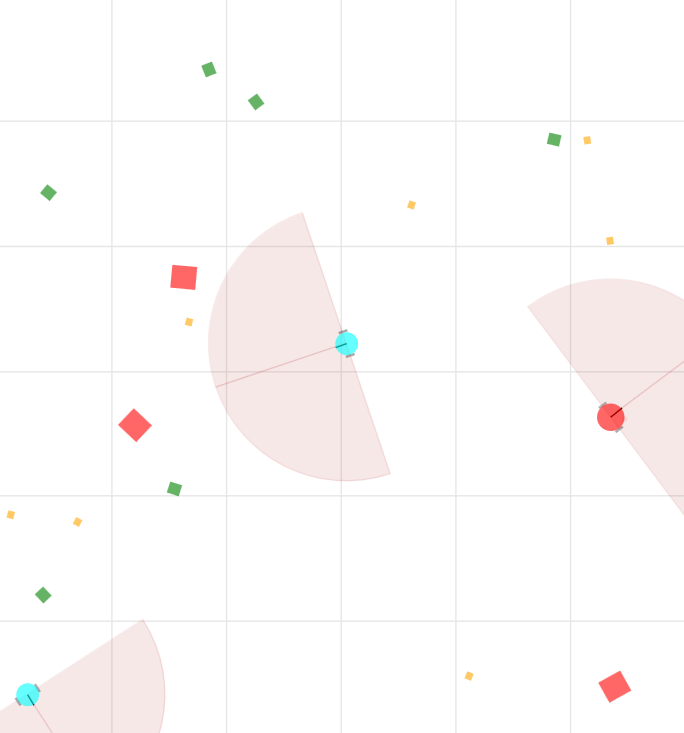

In [45]:
stop_server_and_interface()
controller.stop()

Received signal 15, shutting down
Server and Interface Stopped
